In [2]:
!pip install praw


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install wordcloud


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import praw
import pandas as pd

reddit = praw.Reddit(
   client_id = '5qJRHRvQPyfpilGjxicAsQ',
   client_secret = 'yev-bSPFp5_czyT4ypp4VuXT14omWA',
   user_agent = 'praw')

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    # 'limit' parameter can be increased 
    # in order to expand more comments
    submission.comments.replace_more(limit=64)
    print(len(commentsList))
    i = 0
    for c in commentsList:
        if isinstance(c, praw.models.MoreComments):
            continue
        commentText = c.body
        if commentText in {'[deleted]', '[removed]'}:
            continue
        pandas_list.append([i, commentText])
        i+=1
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [6]:
corpus = getComments('1detli')

print(corpus.shape)
corpus.head()

902
(452, 2)


,id,description
0,0,My father passed away last year. One item he ...
1,1,My mom told me this story the other day and it...
2,2,"When I was 15, my mother and I were standing i..."
3,3,Scariest moment of my life happened while my f...
4,4,I saw a 'shadow person' once.\n\nI didn't know...


In [7]:
print('First spooky story : ',corpus.loc[0,'description'])

First spooky story :  My father passed away last year.  One item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather.  For years he had this shotgun stashed in the attic.  After he passed, I had gone in the attic to look for it, only to find that it wasn't there.

A few months later, I had a dream in which I was talking to him and I asked him where he had put the shotgun.  He told me it was in the closet of a spare bedroom.  I called my mother and had her check, and sure enough that's where it was.

Now it's completely possible that my father had told me that when he was alive, and the dream was little more than a memory, but I certainly don't recall that being the case.


In [8]:
### Removing HTML elements
import re
from bs4 import BeautifulSoup

corpus['clean_description'] = corpus['description'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
corpus['clean_description'] = corpus['clean_description'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

print('Description cleaned of the first product:', corpus.loc[0, 'clean_description'])

Description cleaned of the first product: My father passed away last year  One item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather  For years he had this shotgun stashed in the attic  After he passed I had gone in the attic to look for it only to find that it wasnt there

A few months later I had a dream in which I was talking to him and I asked him where he had put the shotgun  He told me it was in the closet of a spare bedroom  I called my mother and had her check and sure enough thats where it was

Now its completely possible that my father had told me that when he was alive and the dream was little more than a memory but I certainly dont recall that being the case


C:\Users\Matthew\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
### to lowercase
corpus['clean_description'] = corpus['clean_description'].apply(lambda x: x.lower())
print('First story lower-cased:', corpus.loc[0, 'clean_description'])

First story lower-cased: my father passed away last year  one item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather  for years he had this shotgun stashed in the attic  after he passed i had gone in the attic to look for it only to find that it wasnt there

a few months later i had a dream in which i was talking to him and i asked him where he had put the shotgun  he told me it was in the closet of a spare bedroom  i called my mother and had her check and sure enough thats where it was

now its completely possible that my father had told me that when he was alive and the dream was little more than a memory but i certainly dont recall that being the case


In [10]:
### tokenizing
from nltk.tokenize import word_tokenize

corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: word_tokenize(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,My father passed away last year. One item he ...,my father passed away last year one item he a...,"[my, father, passed, away, last, year, one, it..."
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[my, mom, told, me, this, story, the, other, d..."
2,2,"When I was 15, my mother and I were standing i...",when i was my mother and i were standing in t...,"[when, i, was, my, mother, and, i, were, stand..."
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scariest, moment, of, my, life, happened, whi..."
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a shadow person once\n\ni didnt know tha...,"[i, saw, a, shadow, person, once, i, didnt, kn..."


In [12]:
### removing stop words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    lemmatized_tokens = []
    for token in tokens:
        if token not in stop_words:
            pos = pos_tag([token])[0][1]
            if pos.startswith('NN'):
                lemma = lemmatizer.lemmatize(token, pos='n') 
            elif pos.startswith('VB'):
                lemma = lemmatizer.lemmatize(token, pos='v')  
            elif pos.startswith('JJ'):
                lemma = lemmatizer.lemmatize(token, pos='a')
            else:
                lemma = lemmatizer.lemmatize(token)
            lemmatized_tokens.append(lemma)
    return lemmatized_tokens

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lemmatize)
corpus.head()

,id,description,clean_description,clean_tokens
0,0,My father passed away last year. One item he ...,my father passed away last year one item he a...,"[father, pass, away, last, year, one, item, al..."
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[mom, told, story, day, freak, fuck, old, sist..."
2,2,"When I was 15, my mother and I were standing i...",when i was my mother and i were standing in t...,"[mother, stand, kitchen, talk, rack, wall, hol..."
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scariest, moment, life, happen, friend, camp,..."
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a shadow person once\n\ni didnt know tha...,"[saw, shadow, person, didnt, know, thats, call..."


In [13]:
### tokens in one string
corpus["clean_document"] = corpus["clean_tokens"].apply(lambda tokens: ' '.join(tokens))
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,My father passed away last year. One item he ...,my father passed away last year one item he a...,"[father, pass, away, last, year, one, item, al...",father pass away last year one item always say...
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[mom, told, story, day, freak, fuck, old, sist...",mom told story day freak fuck old sister littl...
2,2,"When I was 15, my mother and I were standing i...",when i was my mother and i were standing in t...,"[mother, stand, kitchen, talk, rack, wall, hol...",mother stand kitchen talk rack wall hold key f...
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scariest, moment, life, happen, friend, camp,...",scariest moment life happen friend camp easter...
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a shadow person once\n\ni didnt know tha...,"[saw, shadow, person, didnt, know, thats, call...",saw shadow person didnt know thats call much l...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(452, 3890)


In [15]:
from sklearn.decomposition import TruncatedSVD
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.194206,-0.054334,-0.146266,0.070691,0.047308,-0.013478,-0.021272,-0.132885,0.007865,-0.065865,0.000625,0.057229,my father passed away last year one item he a...
1,0.244729,-0.027091,-0.217502,0.165718,-0.173182,0.076039,-0.082212,0.009553,-0.095894,-0.113373,0.120252,-0.034612,my mom told me this story the other day and it...
2,0.175641,-0.014877,-0.040533,-0.108581,-0.054113,0.047837,-0.037210,-0.057419,-0.031586,-0.010133,-0.136703,-0.050744,when i was my mother and i were standing in t...
3,0.265184,-0.076804,0.079033,-0.048156,0.000851,0.006148,-0.014230,-0.066360,0.320974,0.149789,0.110801,-0.162174,scariest moment of my life happened while my f...
4,0.387322,0.001075,0.102211,-0.078247,-0.043706,0.006179,-0.001072,-0.077206,0.034675,0.044022,-0.055866,0.028146,i saw a shadow person once\n\ni didnt know tha...


In [16]:
import numpy as np

def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is the one that has the maximum value for each row.
    """
    main_topic = x.idxmax() 
    return main_topic

topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:, :-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.194206,-0.054334,-0.146266,0.070691,0.047308,-0.013478,-0.021272,-0.132885,0.007865,-0.065865,0.000625,0.057229,my father passed away last year one item he a...,topic_0
1,0.244729,-0.027091,-0.217502,0.165718,-0.173182,0.076039,-0.082212,0.009553,-0.095894,-0.113373,0.120252,-0.034612,my mom told me this story the other day and it...,topic_0
2,0.175641,-0.014877,-0.040533,-0.108581,-0.054113,0.047837,-0.037210,-0.057419,-0.031586,-0.010133,-0.136703,-0.050744,when i was my mother and i were standing in t...,topic_0
3,0.265184,-0.076804,0.079033,-0.048156,0.000851,0.006148,-0.014230,-0.066360,0.320974,0.149789,0.110801,-0.162174,scariest moment of my life happened while my f...,topic_8
4,0.387322,0.001075,0.102211,-0.078247,-0.043706,0.006179,-0.001072,-0.077206,0.034675,0.044022,-0.055866,0.028146,i saw a shadow person once\n\ni didnt know tha...,topic_0


In [17]:
topic_encoded_df['main_topic'].value_counts()

topic_0     236
topic_1      31
topic_3      24
topic_8      22
topic_10     21
topic_6      21
topic_4      20
topic_7      18
topic_11     17
topic_9      16
topic_5      13
topic_2      13
Name: main_topic, dtype: int64

In [18]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,aaaand,aaand,abandon,abduct,abduction,ability,abject,able,aboard,abominably,...,youll,young,youre,youth,yukon,zag,zig,zimbabwe,zinc,zone
topic_0,0.000818,0.000737,0.006185,0.001969,0.002801,0.007198,0.002443,0.024238,0.001047,0.000819,...,0.005485,0.050590,0.028626,0.001683,0.002983,0.002197,0.002197,0.001252,0.002007,0.002972
topic_1,0.000695,0.000416,0.001929,0.001354,0.001997,0.035459,0.001596,0.008420,0.000590,0.000264,...,0.002917,0.023790,0.060126,0.000816,0.002311,0.002115,0.002115,0.000411,0.000029,0.001647
topic_2,0.000140,0.002525,0.006328,0.000249,0.001508,0.002526,0.017108,0.022070,0.000198,0.000437,...,0.002141,0.004828,0.002185,0.000326,0.003794,0.001989,0.001989,0.000108,0.001977,0.001852
topic_3,0.000251,0.001789,0.002415,0.000002,0.007953,0.000628,0.016526,0.005610,0.000527,0.000777,...,0.000351,0.017945,0.001293,0.000084,0.005037,0.000958,0.000958,0.000856,0.001566,0.002810
topic_4,0.001364,0.007039,0.005196,0.006012,0.015221,0.024681,0.012951,0.003695,0.000487,0.000160,...,0.002097,0.042080,0.091849,0.001572,0.003992,0.000383,0.000383,0.001160,0.001131,0.000468


In [20]:
# Loop over each topic and print the 5 most important words
for i, row in topics_description.iterrows():
    top_words = row.nlargest(5)  
    print(f"Topic {i}:")
    print(top_words)
    print("\n")

Topic topic_0:
like     0.186672
time     0.174033
say      0.168124
house    0.166739
look     0.146466
Name: topic_0, dtype: float64


Topic topic_1:
ghost      0.838936
nice       0.210608
thats      0.121598
mean       0.109784
asshole    0.101385
Name: topic_1, dtype: float64


Topic topic_2:
fuck       0.356713
say        0.293088
mom        0.270977
story      0.235857
grandma    0.198341
Name: topic_2, dtype: float64


Topic topic_3:
fuck     0.357752
story    0.337632
door     0.281046
open     0.229475
house    0.185072
Name: topic_3, dtype: float64


Topic topic_4:
alien    0.398378
dream    0.313388
fuck     0.295575
im       0.189100
mom      0.166493
Name: topic_4, dtype: float64


Topic topic_5:
alien      0.502089
dude       0.244235
im         0.223587
fuck       0.220567
grandma    0.216140
Name: topic_5, dtype: float64


Topic topic_6:
shit     0.509411
story    0.226991
love     0.220612
scare    0.193139
time     0.175628
Name: topic_6, dtype: float64


Topic topic

-------------------------

TOPIC  topic_0


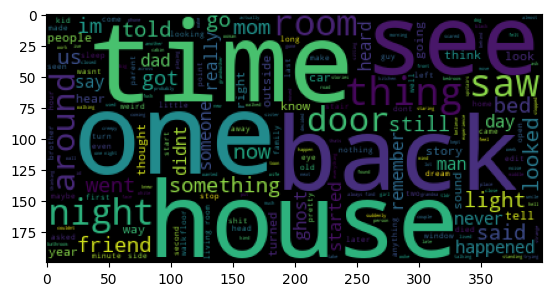


-------------------------

TOPIC  topic_1


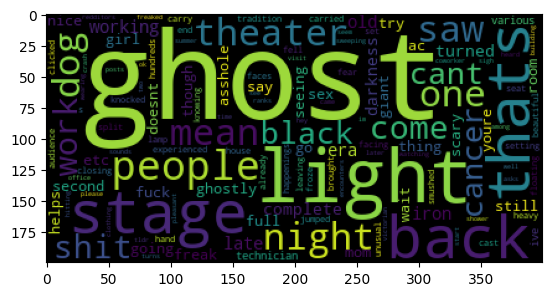


-------------------------

TOPIC  topic_2


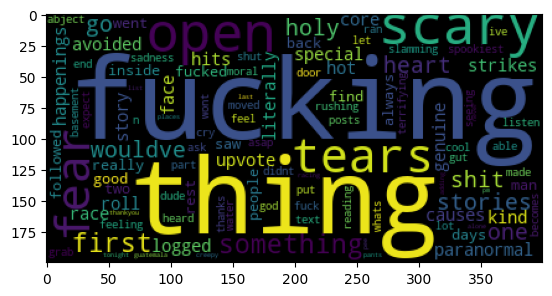


-------------------------

TOPIC  topic_3


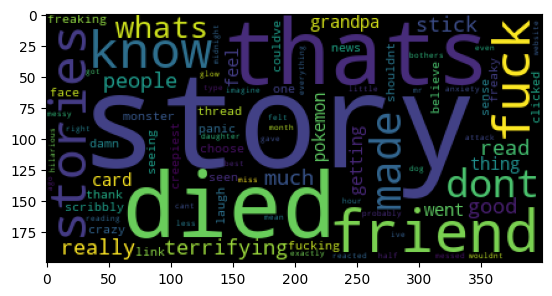


-------------------------

TOPIC  topic_4


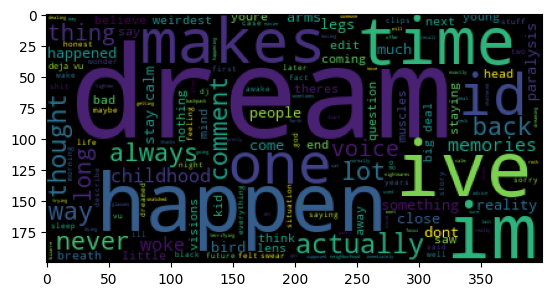


-------------------------

TOPIC  topic_5


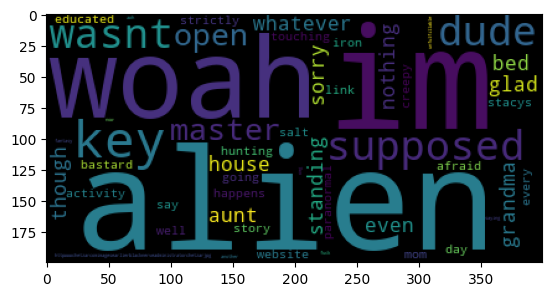


-------------------------

TOPIC  topic_6


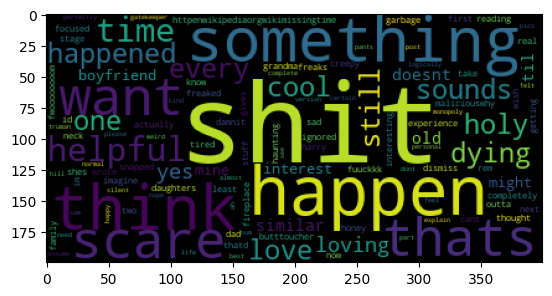


-------------------------

TOPIC  topic_7


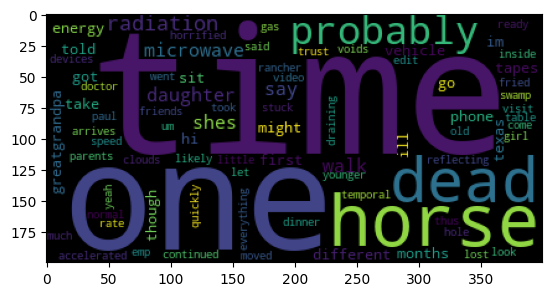


-------------------------

TOPIC  topic_8


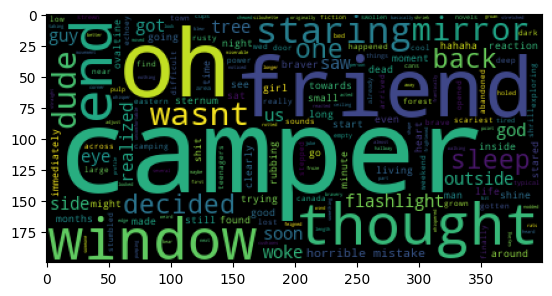


-------------------------

TOPIC  topic_9


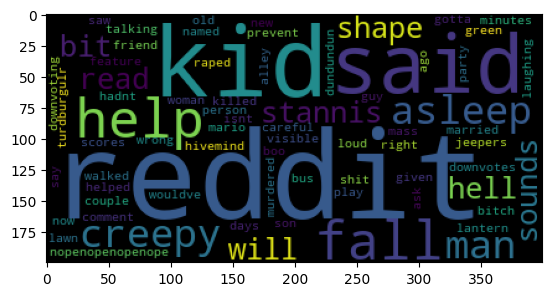


-------------------------

TOPIC  topic_10


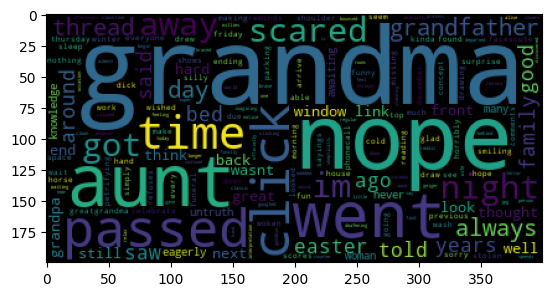


-------------------------

TOPIC  topic_11


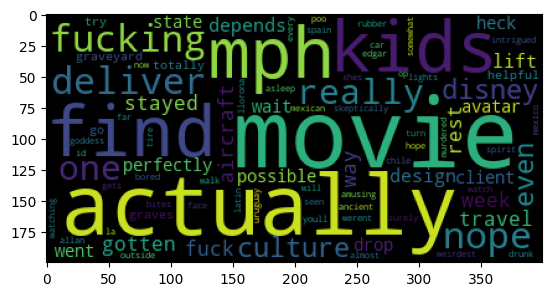

In [21]:
import wordcloud
import matplotlib.pyplot as plt

# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

In [22]:
### use doc2vec insted of TF-IDF
import gensim

from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

corpus['tokens'] = corpus['clean_document'].apply(preprocess_text)
tagged_data = [gensim.models.doc2vec.TaggedDocument(words=row['tokens'], tags=[str(i)]) for i, row in corpus.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
doc_vectors = [model.infer_vector(row['tokens']) for _, row in corpus.iterrows()]

X = np.array(doc_vectors)

print(X.shape)

(452, 100)


In [23]:
from sklearn.decomposition import TruncatedSVD
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,4.492824,-0.725603,0.165234,1.498544,-0.107609,-0.357370,-0.358582,0.765427,-1.080867,-0.509101,-1.427766,-1.561551,my father passed away last year one item he a...
1,5.329550,-2.100224,-0.177693,1.687565,1.390427,-1.045557,-0.091373,0.797883,-0.357479,-1.163499,0.320306,0.607647,my mom told me this story the other day and it...
2,3.617241,0.199478,-0.288901,-1.097422,1.051560,0.173064,0.347423,0.506582,-1.375858,0.080292,-1.034891,2.114207,when i was my mother and i were standing in t...
3,8.943189,5.459993,-2.462093,-1.686931,-5.818691,3.626627,-3.376399,-1.933928,-2.713252,-0.330097,-1.502132,0.620120,scariest moment of my life happened while my f...
4,8.212732,2.379851,1.802192,-6.478449,-2.912303,-1.618515,-0.818660,-2.981638,1.963244,0.599012,-6.306470,0.962612,i saw a shadow person once\n\ni didnt know tha...


In [25]:
import numpy as np

def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is the one that has the maximum value for each row.
    """
    main_topic = x.idxmax() 
    return main_topic

topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:, :-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,4.492824,-0.725603,0.165234,1.498544,-0.107609,-0.357370,-0.358582,0.765427,-1.080867,-0.509101,-1.427766,-1.561551,my father passed away last year one item he a...,topic_0
1,5.329550,-2.100224,-0.177693,1.687565,1.390427,-1.045557,-0.091373,0.797883,-0.357479,-1.163499,0.320306,0.607647,my mom told me this story the other day and it...,topic_0
2,3.617241,0.199478,-0.288901,-1.097422,1.051560,0.173064,0.347423,0.506582,-1.375858,0.080292,-1.034891,2.114207,when i was my mother and i were standing in t...,topic_0
3,8.943189,5.459993,-2.462093,-1.686931,-5.818691,3.626627,-3.376399,-1.933928,-2.713252,-0.330097,-1.502132,0.620120,scariest moment of my life happened while my f...,topic_0
4,8.212732,2.379851,1.802192,-6.478449,-2.912303,-1.618515,-0.818660,-2.981638,1.963244,0.599012,-6.306470,0.962612,i saw a shadow person once\n\ni didnt know tha...,topic_0


In [26]:
topic_encoded_df['main_topic'].value_counts()

topic_0     440
topic_3       3
topic_4       3
topic_6       1
topic_5       1
topic_1       1
topic_10      1
topic_2       1
topic_9       1
Name: main_topic, dtype: int64

In [27]:
topics_description = pd.DataFrame(svd_model.components_[:, :100], 
                                  columns=vectorizer.get_feature_names_out()[:100], 
                                  index=['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis=1)

# Each word is mapped with a score of relevance for each topic
topics_description.head()

,aaaand,aaand,abandon,abduct,abduction,ability,abject,able,aboard,abominably,...,alcohol,alert,alien,alive,allan,allergic,alley,allow,alongside,alright
topic_0,0.068122,0.013255,0.016417,0.074015,0.045998,0.125081,0.078960,0.163010,0.091668,0.024417,...,0.150720,0.140378,0.011558,0.000254,0.154357,0.049257,0.014679,0.121149,0.055950,0.016966
topic_1,0.090442,0.063747,0.148817,0.016672,0.043841,0.023150,0.066144,0.050988,0.103891,0.037234,...,0.074238,0.018731,0.028364,0.123525,0.025029,0.096145,0.101441,0.087209,0.029377,0.104769
topic_2,0.061421,0.021203,0.063080,0.107623,0.087459,0.036067,0.031468,0.091250,0.039421,0.130740,...,0.123287,0.000930,0.010232,0.047940,0.064384,0.055326,0.134163,0.052629,0.292166,0.064109
topic_3,0.009138,0.217436,0.003883,0.007591,0.163423,0.281499,0.007014,0.155967,0.200000,0.022418,...,0.069872,0.079480,0.032985,0.113283,0.092445,0.097473,0.031890,0.028491,0.001986,0.095946
topic_4,0.096205,0.025366,0.052498,0.166181,0.050175,0.023694,0.146188,0.045047,0.054916,0.027727,...,0.007799,0.007346,0.038080,0.142596,0.023816,0.079120,0.087624,0.040807,0.014278,0.144986


In [28]:
for i, row in topics_description.iterrows():
    top_words = row.nlargest(5)  
    print(f"Topic {i}:")
    print(top_words)
    print("\n")

Topic topic_0:
air               0.259965
access            0.202392
absentmindedly    0.195862
advise            0.189946
activity          0.181775
Name: topic_0, dtype: float32


Topic topic_1:
acknowledge    0.258992
access         0.251432
abruptly       0.245774
aggressive     0.192657
accompany      0.191500
Name: topic_1, dtype: float32


Topic topic_2:
administration    0.292347
alongside         0.292166
album             0.257809
accuse            0.226097
advanced          0.182925
Name: topic_2, dtype: float32


Topic topic_3:
ability     0.281499
aaand       0.217436
abruptly    0.212936
affected    0.206731
aboard      0.200000
Name: topic_3, dtype: float32


Topic topic_4:
accurate     0.273554
air          0.259629
aimless      0.241794
ah           0.237342
afterward    0.200486
Name: topic_4, dtype: float32


Topic topic_5:
age         0.291487
actor       0.260171
ahead       0.245319
alley       0.224521
aircraft    0.221646
Name: topic_5, dtype: float32


Topic to

-------------------------

TOPIC  topic_0


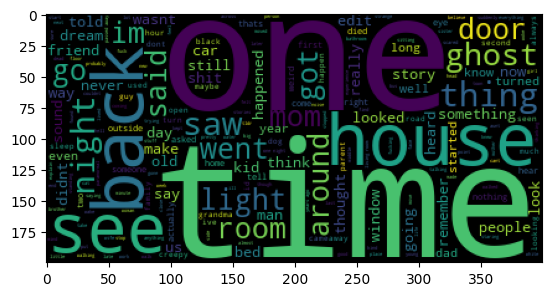


-------------------------

TOPIC  topic_1


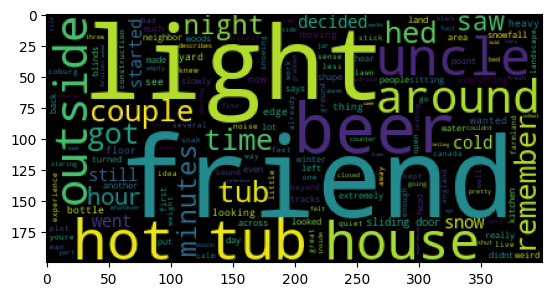


-------------------------

TOPIC  topic_2


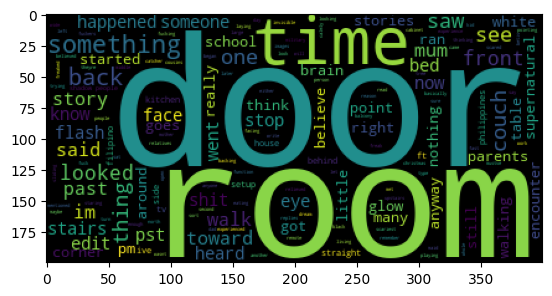


-------------------------

TOPIC  topic_3


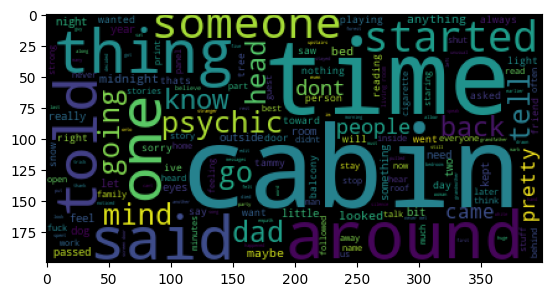


-------------------------

TOPIC  topic_4


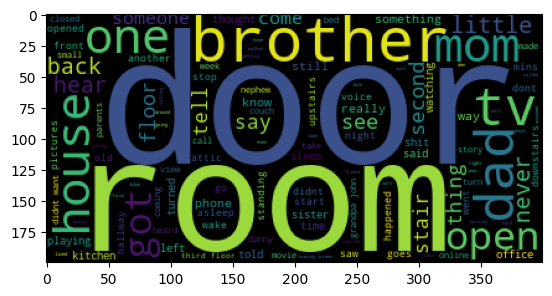


-------------------------

TOPIC  topic_5


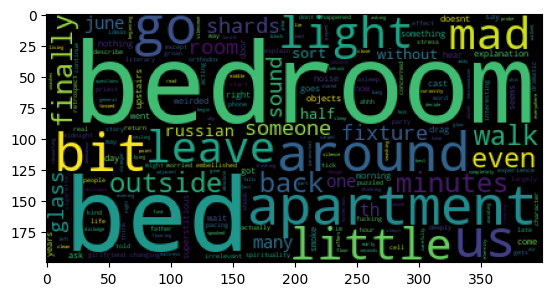


-------------------------

TOPIC  topic_6


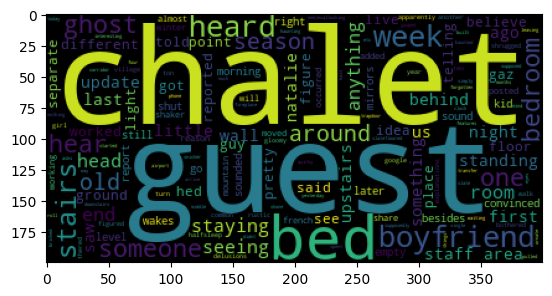


-------------------------

TOPIC  topic_7
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_8
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_9


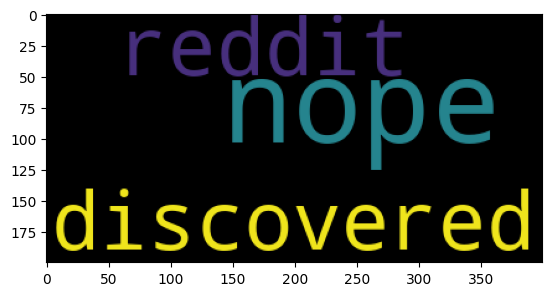


-------------------------

TOPIC  topic_10


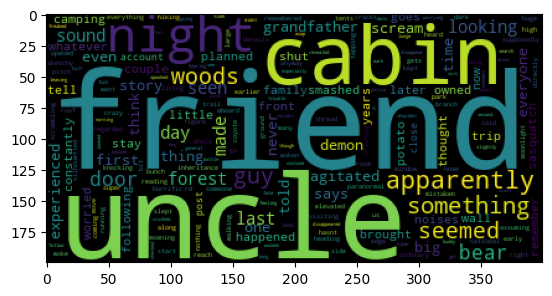


-------------------------

TOPIC  topic_11
cannot create wordcloud for this topic


In [29]:
import wordcloud
import matplotlib.pyplot as plt

wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

C:\Users\Matthew\AppData\Local\Temp\ipykernel_392\211314082.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(x='TSNE-1', y='TSNE-2', data=topic_2d_df,


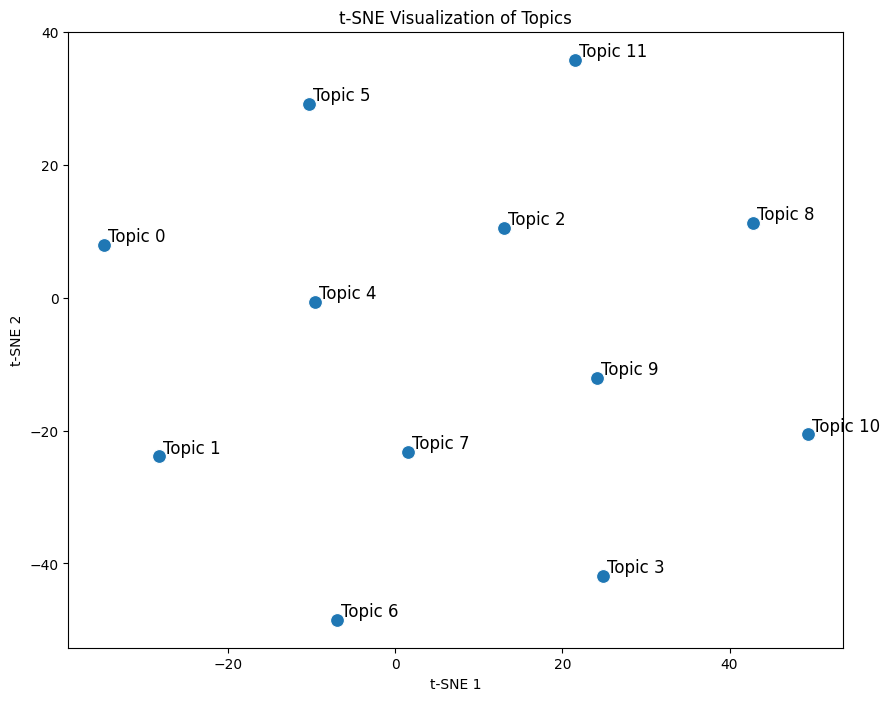

In [34]:
### Add SNE visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

topic_vectors = svd_model.components_

n_topics = topic_vectors.shape[0]
perplexity_value = min(30, n_topics - 1)  
tsne = TSNE(n_components=2, 
            random_state=42,
            perplexity=perplexity_value,  
            init='pca',  
            learning_rate='auto')  

topic_2d = tsne.fit_transform(topic_vectors)
topic_2d_df = pd.DataFrame(topic_2d, columns=['TSNE-1', 'TSNE-2'])

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='TSNE-1', y='TSNE-2', data=topic_2d_df, 
                         palette="viridis", s=100)

for i in range(len(topic_2d_df)):
    plt.text(topic_2d_df.loc[i, 'TSNE-1'] + 0.5,  
             topic_2d_df.loc[i, 'TSNE-2'] + 0.5,
             f'Topic {i}', 
             fontsize=12)

plt.title('t-SNE Visualization of Topics')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()